In [575]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import tensorflow as tf
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras import layers
!pip install shap

import sklearn
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

First create some toy data to play with.

In [665]:
airplanes = pd.read_csv('Airplane geometry.csv')
TS = airplanes['Top Speed (mph)']
mach = TS/767.269;
length = airplanes['Length (ft)']
length = length/218;
height = airplanes['Height (ft)']
height = height/79;
wingspan = airplanes['Wingspan (ft)']
wingspan = wingspan/320;
wingchord = airplanes['Wing Chord (ft)']
wingchord = wingchord/51;
numengine = airplanes['Number of Engines']
numengine = numengine/8;
AR = airplanes['Wing Aspect Ratio']
AR = AR/30;
enginetype = airplanes['Engine Type']
enginetype = enginetype/5;
pilots = airplanes['Number of Pilots']
pilots = pilots/2;

# let's put these dummy temperatures into an xarray dataset
ds = xr.Dataset(
    {
        'length': (['plane'], length),
        'height': (['plane'], height),
        'AR': (['plane'], AR),
        'wingspan': (['plane'], wingspan),
        'wingchord': (['plane'], wingchord),
        'numengine': (['plane'], numengine),
        #'enginetype':(['plane'], one_hot),
        'enginetype':(['plane'], enginetype),
        'pilots': (['plane'], pilots),
        'mach': (['plane'], mach),
        
    },
)

# np.random.seed(123)

In [667]:
# what does this look like
ds

<xarray.Dataset>
Dimensions:     (plane: 88)
Dimensions without coordinates: plane
Data variables:
    length      (plane) float64 0.1101 0.1239 0.1009 ... 0.2752 0.2202 0.2358
    height      (plane) float64 0.1051 0.1127 0.1013 ... 0.2025 0.1747 0.1772
    AR          (plane) float64 0.24 0.2433 0.2167 0.28 ... 0.1067 0.09667 0.1
    wingspan    (plane) float64 0.1034 0.1125 0.1031 ... 0.14 0.08375 0.1094
    wingchord   (plane) float64 0.1118 0.1196 0.1078 ... 0.2745 0.1961 0.2608
    numengine   (plane) float64 0.125 0.125 0.125 0.125 ... 0.25 0.125 0.125
    enginetype  (plane) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.4 0.6 0.6 0.6 0.6
    pilots      (plane) float64 0.5 0.5 0.5 0.5 0.5 0.5 ... 1.0 0.5 0.5 0.5 0.5
    mach        (plane) float64 0.1395 0.2085 0.1108 ... 1.551 1.694 1.564

In [669]:
ds.to_dataframe()

,length,height,AR,wingspan,wingchord,numengine,enginetype,pilots,mach
plane,,,,,,,,,
0,0.110092,0.105063,0.240000,0.103438,0.111765,0.125,0.2,0.5,0.139456
1,0.123853,0.112658,0.243333,0.112500,0.119608,0.125,0.2,0.5,0.208532
2,0.100917,0.101266,0.216667,0.103125,0.107843,0.125,0.2,0.5,0.110783
3,0.113303,0.098734,0.280000,0.112500,0.115686,0.125,0.2,0.5,0.332348
4,0.118807,0.106329,0.266667,0.109375,0.119608,0.125,0.2,0.5,0.260665
...,...,...,...,...,...,...,...,...,...
83,0.494495,0.346835,0.266667,0.291563,0.264706,0.250,0.4,1.0,0.539576
84,0.256881,0.193671,0.100000,0.126250,0.264706,0.250,0.6,0.5,1.550955
85,0.275229,0.202532,0.106667,0.140000,0.274510,0.250,0.6,0.5,1.550955


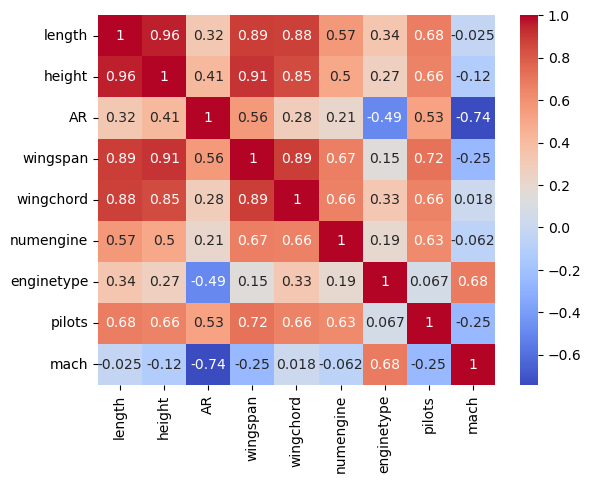

In [671]:
import seaborn as sns
# Calculate the correlation matrix
corr = ds.to_dataframe().corr()

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [673]:
# split by years
# Convert xarray.Dataset to pandas.DataFrame
df = ds.to_dataframe().reset_index()

# Split using scikit-learn
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)

In [675]:
df

,plane,length,height,AR,wingspan,wingchord,numengine,enginetype,pilots,mach
0,0,0.110092,0.105063,0.240000,0.103438,0.111765,0.125,0.2,0.5,0.139456
1,1,0.123853,0.112658,0.243333,0.112500,0.119608,0.125,0.2,0.5,0.208532
2,2,0.100917,0.101266,0.216667,0.103125,0.107843,0.125,0.2,0.5,0.110783
3,3,0.113303,0.098734,0.280000,0.112500,0.115686,0.125,0.2,0.5,0.332348
4,4,0.118807,0.106329,0.266667,0.109375,0.119608,0.125,0.2,0.5,0.260665
...,...,...,...,...,...,...,...,...,...,...
83,83,0.494495,0.346835,0.266667,0.291563,0.264706,0.250,0.4,1.0,0.539576
84,84,0.256881,0.193671,0.100000,0.126250,0.264706,0.250,0.6,0.5,1.550955
85,85,0.275229,0.202532,0.106667,0.140000,0.274510,0.250,0.6,0.5,1.550955
86,86,0.220183,0.174684,0.096667,0.083750,0.196078,0.125,0.6,0.5,1.694321


In [683]:
input_vars = ['length', 'wingspan', 'wingchord', 'AR', 'numengine', 'pilots', 'enginetype', 'height']
target_var = 'mach'

In [685]:
x_train = train_df[input_vars].values
y_train = train_df[target_var].values

x_test = test_df[input_vars].values
y_test = test_df[target_var].values

In [687]:
xr.where((y_train < 1)&(y_train > 0.5), 1., y_train)

array([1.9549858 , 0.26327142, 0.27760798, 2.08531819, 2.02015199,
       1.56398864, 1.        , 1.        , 0.11078253, 1.86375313,
       2.02015199, 1.5509554 , 1.76470052, 1.        , 1.9549858 ,
       1.07524219, 0.25805813, 1.        , 1.        , 1.24728094,
       1.91979606, 1.        , 1.        , 1.59917838, 0.26978804,
       2.02015199, 1.        , 2.08531819, 1.9549858 , 1.        ,
       1.        , 1.        , 1.69432103, 1.        , 0.26066477,
       1.        , 2.60925438, 1.        , 0.33234759, 2.72916018,
       0.40663705, 1.        , 1.        , 1.79858694, 1.        ,
       1.75948722, 0.47701654, 1.        , 2.44373225, 0.13945565,
       0.4314002 , 1.        , 0.37405395, 1.        , 0.27500134,
       1.5509554 , 1.        , 1.17299148, 1.        , 1.        ,
       1.        , 1.        , 1.        , 2.85818924, 1.        ,
       0.39099716, 0.27369801, 2.42418239, 0.48222983, 0.20853182,
       1.56398864, 5.89102388, 1.        , 0.21244179, 1.     

In [689]:
y_train

array([1.9549858 , 0.26327142, 0.27760798, 2.08531819, 2.02015199,
       1.56398864, 0.79111759, 0.75983781, 0.11078253, 1.86375313,
       2.02015199, 1.5509554 , 1.76470052, 0.67772841, 1.9549858 ,
       1.07524219, 0.25805813, 0.56955253, 0.84716051, 1.24728094,
       1.91979606, 0.9449098 , 0.70900818, 1.59917838, 0.26978804,
       2.02015199, 0.53957608, 2.08531819, 1.9549858 , 0.55521597,
       0.83934057, 0.79111759, 1.69432103, 0.70900818, 0.26066477,
       0.74028796, 2.60925438, 0.53957608, 0.33234759, 2.72916018,
       0.40663705, 0.74941122, 0.87713696, 1.79858694, 0.79372423,
       1.75948722, 0.47701654, 0.61907884, 2.44373225, 0.13945565,
       0.4314002 , 0.82630733, 0.37405395, 0.73898463, 0.27500134,
       1.5509554 , 0.76896108, 1.17299148, 0.80024085, 0.69076165,
       0.84716051, 0.6659985 , 0.82109404, 2.85818924, 0.82370068,
       0.39099716, 0.27369801, 2.42418239, 0.48222983, 0.20853182,
       1.56398864, 5.89102388, 0.70379489, 0.21244179, 0.50959

In [691]:
def make_labels(ytmp):
    ytmp = xr.where(ytmp >= 1, 2., ytmp)
    ytmp = xr.where((ytmp < 1)&(ytmp > 0.5), 1., ytmp)
    return xr.where(ytmp <= 0.5, 0., ytmp)

In [693]:
label_train_scaled = make_labels(y_train)
label_test_scaled = make_labels(y_test)

In [695]:
label_train_scaled

array([2., 0., 0., 2., 2., 2., 1., 1., 0., 2., 2., 2., 2., 1., 2., 2., 0.,
       1., 1., 2., 2., 1., 1., 2., 0., 2., 1., 2., 2., 1., 1., 1., 2., 1.,
       0., 1., 2., 1., 0., 2., 0., 1., 1., 2., 1., 2., 0., 1., 2., 0., 0.,
       1., 0., 1., 0., 2., 1., 2., 1., 1., 1., 1., 1., 2., 1., 0., 0., 2.,
       0., 0., 2., 2., 1., 0., 1., 0., 1., 1., 2.])

(array([19., 31., 29.]),
 array([0., 1., 2., 3.]),
 <BarContainer object of 3 artists>)

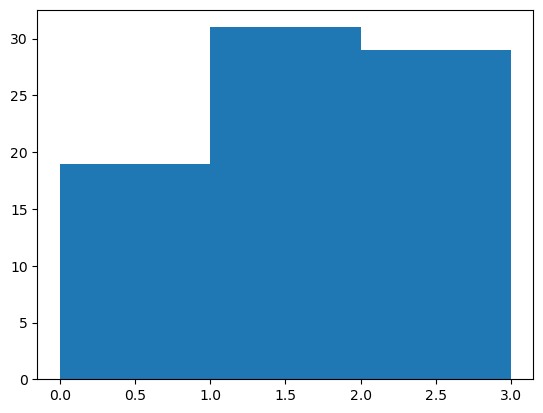

In [697]:
plt.hist(label_train_scaled, bins=[0,1,2,3])  # index into the first "location"

In [699]:
# Create OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[ [0, 1, 2] ],sparse_output=False)
# Fit and transform the data
label_train_scaled = encoder.fit_transform(label_train_scaled.reshape(-1, 1))
label_test_scaled = encoder.fit_transform(label_test_scaled.reshape(-1, 1))

In [701]:
label_train_scaled

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

In [703]:
# now, let's create a new ANN
# most things will be consistent to the earlier example
keras.utils.set_random_seed(1)

model = keras.Sequential() # instantiate model object
model.add(keras.Input(shape=(8,), name="input_layer"))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu)) #changed from sigmoid
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu)) #changed from sigmoid
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu)) #changed from sigmoid
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu)) #changed from sigmoid

In [705]:
# our first change is the output layer activation function (now sigmoid instead of linear)
model.add(keras.layers.Dense(units=3, activation='softmax'))

In [707]:
# and our loss function now is binary cross entropy
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.CategoricalCrossentropy()
    ,metrics=['accuracy']
    #loss='mse'
)

In [709]:
# check out the new model
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315 (1.23 KB)

 Trainable params: 315 (1.23 KB)

 Non-trainable params: 0 (0.00 B)

In [711]:
history = model.fit(
    x=x_train,
    y=label_train_scaled,
    batch_size=8,
    epochs=100,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3562 - loss: 1.0870 - val_accuracy: 0.5000 - val_loss: 1.0521
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4272 - loss: 1.0246 - val_accuracy: 0.6250 - val_loss: 0.9868
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5597 - loss: 0.9499 - val_accuracy: 0.6250 - val_loss: 0.9341
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6831 - loss: 0.8330 - val_accuracy: 0.6250 - val_loss: 0.8557
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7066 - loss: 0.6960 - val_accuracy: 0.6250 - val_loss: 0.7874
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8162 - loss: 0.5798 - val_accuracy: 0.6250 - val_loss: 0.8082
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8316 - loss: 0.4940 - val_accuracy: 0.6250 - val_loss: 0.8693
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8341 - loss: 0.4458 - val_accuracy: 0.6250 - val_loss: 0.8165

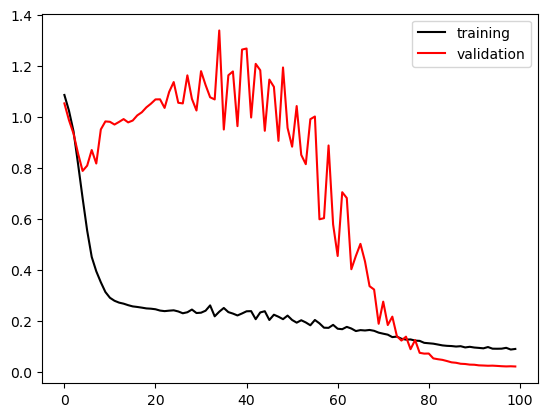

In [712]:
plt.plot(range(0,100), history.history['loss'], c='k', label='training')
plt.plot(range(0,100), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

In [713]:
loss, accuracy = model.evaluate(x_test, label_test_scaled, batch_size=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0105      
Test Loss: 0.00866624340415001
Test Accuracy: 1.0


In [714]:
#X ai analysis
import shap
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
!pip install tf-keras



In [715]:
preds = model.predict(x_test)
score = r2_score(label_test_scaled, preds)
print(f"R2 Score: {score:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
R2 Score: 0.666


In [716]:
def permutation_feature_importance(model, X, y, metric=None, n_repeats=5, seed=42):
    """
    Compute permutation feature importance for a Keras regression model.

    Parameters:
    - model: trained Keras model
    - X: numpy array of shape (n_samples, n_features)
    - y: true target values, shape (n_samples,)
    - metric: function to evaluate performance, default is mean squared error
    - n_repeats: number of shuffles per feature
    - seed: random seed for reproducibility

    Returns:
    - Dictionary mapping feature index to importance score
    """
    np.random.seed(seed)
    if metric is None:
        def metric(y_true, y_pred):
            return np.mean((y_true - y_pred) ** 2)  # MSE

    baseline_score = metric(y, model.predict(X))
    importances = {}

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])  # Shuffle only the i-th column
            permuted_score = metric(y, model.predict(X_perm))
            scores.append(permuted_score)
        importances[i] = np.mean(scores) - baseline_score  # Increase in error

    return importances

In [717]:
permutation_feature_importance(model, x_test, label_test_scaled, metric=None, n_repeats=5, seed=42)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

{0: 0.2119261257974844,
 1: 0.21804429079388124,
 2: -6.822271809530263e-05,
 3: 0.3716898314719468,
 4: 0.00015773803793491564,
 5: 0.033820396882794576,
 6: 0.003232591264520893,
 7: 0.3340032794279597}

In [718]:
#SHAP
X100 = shap.utils.sample(x_train, 100)  # 100 instances for use as the background distribution

explainer = shap.Explainer(model, X100)
shap_vals = explainer(x_test)

C:\Users\brett\AppData\Local\Temp\ipykernel_20536\117995508.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, x_test, feature_names=feature_names)


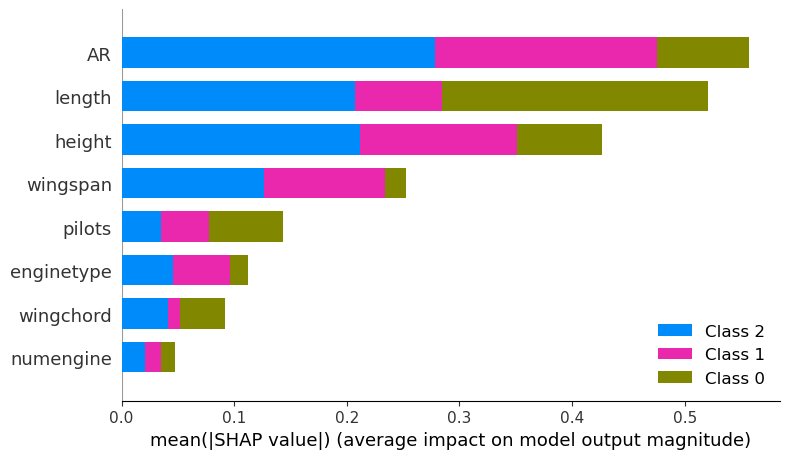

In [719]:
feature_names = input_vars#x_train.columns
# Create a SHAP beeswarm plot, colored by feature values when they are provided.
shap.summary_plot(shap_vals, x_test, feature_names=feature_names)

PyALE._ALE_generic:INFO: Continuous feature detected.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


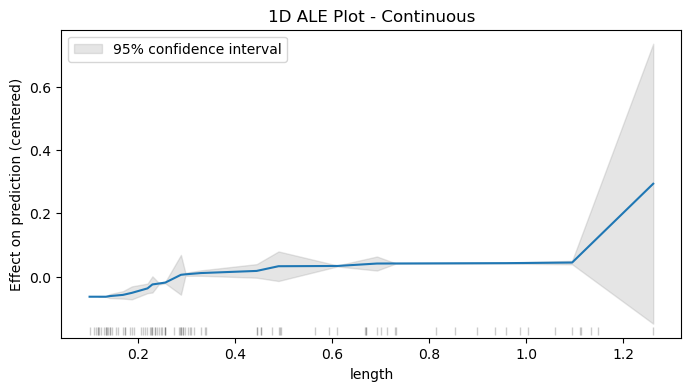

In [720]:
from PyALE import ale

class KerasMulticlassWrapper:
    def __init__(self, keras_model, class_index):
        self.model = keras_model
        self.class_index = 2  # 0, 1, or 2 for your case

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        y_pred = self.model.predict(X)
        return y_pred[:, self.class_index]  # Return probabilities for the desired class

# 2. Create your DataFrame if it's not already one
X_df = pd.DataFrame(df, columns=input_vars)

# 3. Wrap your trained Keras model
wrapped_model = KerasMulticlassWrapper(model, class_index=2)

# 4. Generate ALE plot
ale_eff = ale(
    X=X_df,
    model=wrapped_model,
    feature=['length'],   # Replace with desired feature
    include_CI=True,
    grid_size=20,
)

plt.show()